In [1]:
from lusidtools.jupyter_tools import toggle_code

"""Interest Rate Swap Valuation

Demonstrates pricing of an Interes Rate Swap based on a user defined Instrument.

Attributes
----------
instruments
aggregation
market data store
results store
quotes
"""

toggle_code("Hide docstring")

## Interest Rate Swap Valuation 

This notebook illustrates construction of an _Interest Rate Swap_ and how its underlying defintions can be setup using the LUSID API, as well as how valuations and aggregations can be run using different endpoints. For valuations, we will be looking to use the 'Discounting' model, which uses a set of user-defined curves to discount each cash flow.

The example instrument we will be constructing is a vanilla interest rate swap with the following parameters:

    -  Coupon Rate: 1%
    -  Start Date: 01/10/2019
    -  Maturity: 10Y
    -  Currency: EUR
    -  Payment Frequency: 6M
    -  Index: Euribor 6M
    -  Side: Receive Float

### Table of contents
- 1. [Setup LUSID and required API objects](#1.-Setup-LUSID-and-required-API-objects)
    * [1.2 Interest Rate Swap Definition](#1.1-Interest-Rate-Swap-Definition)
    * [1.2 Curve and Market Data](#1.2-Curve-and-Market-Data)
    * [1.3 Setup Portfolio](#1.3-Setup-Portfolio)
    * [1.4 Add Transactions](#1.4-Add-Transactions)
- 2. [Valuation](#2.-Valuation)
    * [2.1 Configure the valuation recipe](#2.1-Configure-the-valuation-recipe)
    * [2.2 Aggregation](#2.2-Aggregation)
- 3. [Historical Cash Flows](#3.-Historical-Cash-Flows)
    * [3.1 Update Fixings for Historical Resets](#3.1-Update-Fixings-for-Historical-Resets)
    * [3.2 Create Transactions with Properties](#3.2-Create-Transactions-with-Properties)
    * [3.3 Aggregate Cash Flows](#3.3-Aggregate-Cash-Flows)

## 1. Setup LUSID and required API objects

In [2]:
# Import LUSID
import lusid
import lusid.models as models
from lusidtools.cocoon.cocoon import load_from_data_frame
from lusidtools.cocoon.seed_sample_data import seed_data
from lusidtools.cocoon.cocoon_printer import (
    format_instruments_response,
    format_portfolios_response,
    format_transactions_response,
    format_quotes_response,
)
from lusidtools.pandas_utils.lusid_pandas import lusid_response_to_data_frame

# Import Libraries
from datetime import datetime, timedelta, time
from IPython.display import display_html
import pytz
import pandas as pd
import matplotlib.pyplot as plt
import uuid
from lusidjam.refreshing_token import RefreshingToken
import math
import json
import os

# Authenticate our user and create our API client
secrets_path = "FBN_SECRETS_PATH"

api_factory = lusid.utilities.ApiClientFactory(
        token=RefreshingToken(),
        api_secrets_filename = secrets_path,
        app_name="LusidJupyterNotebook")

print ('LUSID Environment Initialised')
print ('LUSID SDK Version: ', api_factory.build(lusid.api.ApplicationMetadataApi).get_lusid_versions().build_version)

# Setup the apis we'll use in this notebook:
instruments_api = api_factory.build(lusid.api.InstrumentsApi)
aggregation_api = api_factory.build(lusid.AggregationApi)
structured_market_data_api = api_factory.build(lusid.api.StructuredMarketDataApi)
structured_result_data_api = api_factory.build(lusid.api.StructuredResultDataApi)
quotes_api = api_factory.build(lusid.api.QuotesApi)
transaction_portfolios_api = api_factory.build(lusid.api.TransactionPortfoliosApi)
property_definitions_api = api_factory.build(lusid.api.PropertyDefinitionsApi)

LUSID Environment Initialised
LUSID SDK Version:  0.6.5672.0


In [3]:
# Settings and utility functions to display objects and responses more clearly.
pd.set_option('float_format', '{:,.2f}'.format)

def aggregation_result_to_dataframe(aggregation_results):
    return pd.DataFrame(aggregation_results, columns = ['Name', 'Effective At', 'Value'])


### 1.1 Interest Rate Swap Definition

We can begin by settting up the details of the swap which we will feed into LUSID. In this case we will be looking at a 10y aged EUR swap with a historical start date.

In [4]:
# Set swap details for start date and maturity
trade_date = datetime(2019, 10, 1, 0, 0, tzinfo=pytz.utc)
start_date = trade_date

# Create a 10y 'EUR' swap as specified below
effectiveAt = datetime.today().replace(tzinfo=pytz.utc)
end_date_10y = start_date.replace(year=start_date.year + 10)
swapCCY = "EUR"
dom_amount = 50000000
cpn = 0.01

Within LUSID, an interest rate swap will need to be defined by setting each leg's [_flow convention_](https://www.lusid.com/docs/api#operation/UpsertFlowConventions), as shown below. This way we can specify the granular details the leg cash flows will follow, and form the basis of the constructed instrument. 

For the floating leg, we will also use a model from the API that sets the [_index convention_](https://www.lusid.com/docs/api#operation/UpsertIndexConvention), which is where we will seek to specify the Euribor 6M Index and daycount convention.

In [5]:
#create the flow convention for each leg + one for the index

flow_conventionFixed= models.FlowConventions(
    currency="EUR",
    payment_frequency="6M",
    day_count_convention="ThirtyU360",
    roll_convention="ModifiedFollowing",
    holiday_calendars=[],
    settle_days=2,
    reset_days=0
)
flow_conventionFloat = models.FlowConventions(
    currency="EUR",
    payment_frequency="6M",
    day_count_convention="Act360",
    roll_convention="ModifiedFollowing",
    holiday_calendars=[],
    settle_days=2,
    reset_days=0
)

float_leg_idx_conv = models.IndexConvention(
    currency="EUR",
    code="EURIBOR",
    payment_tenor="6M",
    fixing_reference="EUR6M",
    publication_day_lag=0,
    day_count_convention="Act360"
)

Using the above defintions we can move to building the legs of our swap, while also defining basic parameters such as the pay/receive sides for each leg and the rate fixing for our fixed leg. 

In [6]:
# create the leg definitions
float_leg_definition = models.LegDefinition(
    index_convention=float_leg_idx_conv,
    pay_receive="Receive",
    conventions=flow_conventionFloat,
    stub_type="Both",
    notional_exchange_type="None"
)

fixed_leg_definition = models.LegDefinition(
    rate_or_spread=cpn,
    pay_receive="Pay",
    conventions=flow_conventionFixed,
    stub_type="Both",
    notional_exchange_type="None"
)

# create the fixed and floating legs
fixed_leg = models.FixedLeg(
    start_date=start_date,
    maturity_date=end_date_10y,
    notional=dom_amount,
    leg_definition=fixed_leg_definition,
    instrument_type="FixedLeg"
)

floating_leg = models.FloatingLeg(
    start_date=start_date,
    maturity_date=end_date_10y,
    notional=dom_amount,
    leg_definition=float_leg_definition,
    instrument_type="FloatingLeg"
)

With all the leg details defined, we can look to build out the IRS instrument itself using the _Instruments API_, which can then be used to upsert to LUSID. 

In [7]:
irs_legs = [
    fixed_leg,
    floating_leg
]

#create the swap
instrument_definition_10yEURIRS = models.InterestRateSwap(
    start_date=start_date.isoformat(),
    maturity_date=end_date_10y.isoformat(),
    legs=irs_legs,
    instrument_type="InterestRateSwap")


# create instrument definition
swapInstrumentDefinition = models.InstrumentDefinition(
    name="10yEURIRS",
    identifiers={"ClientInternal":models.InstrumentIdValue("Swap001")},
    definition=instrument_definition_10yEURIRS
)
batchUpsertRequest = {"Swap001": swapInstrumentDefinition}

#upsert instrument to LUSID
response = instruments_api.upsert_instruments(
    request_body=batchUpsertRequest)

if response.failed == {}:
    print(f"Instrument {swapInstrumentDefinition.name} was successfully upserted into LUSID")
else:
    print("An error occurred with the above upsert_instruments call, see error message:", response.failed)

Instrument 10yEURIRS was successfully upserted into LUSID


In [8]:
def get_instrument(identifier):
    response = instruments_api.get_instrument(
        identifier_type="ClientInternal",
        identifier=identifier
    )
    return response

# Get and store the instrument response for "Swap001"
response = get_instrument("Swap001")

# Store response leg definitions as dataframes
flt_leg_df = lusid_response_to_data_frame(response.instrument_definition.legs[1])
fix_leg_df = lusid_response_to_data_frame(response.instrument_definition.legs[0])

# Display the leg dataframes
df1_styler = flt_leg_df.style.set_table_attributes("style='display:inline'").set_caption('Floating Leg')
df2_styler = fix_leg_df.style.set_table_attributes("style='display:inline'").set_caption('Fixed Leg')
display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)

,response_values
start_date,2019-10-01 00:00:00+00:00
maturity_date,2029-10-01 00:00:00+00:00
leg_definition.rate_or_spread,0.000000
leg_definition.index_convention.fixing_reference,EUR6M
leg_definition.index_convention.publication_day_lag,0
leg_definition.index_convention.payment_tenor,6M
leg_definition.index_convention.day_count_convention,Act360
leg_definition.index_convention.currency,EUR
leg_definition.index_convention.scope,None
leg_definition.index_convention.code,EURIBOR


### 1.2 Setting up the Curve and Market Data

In order to value the swap we will need to create a curve by which we can determine the present values of the cash flows, as well as build out a forward curve for our floating leg. In this example we are creating a discount curve using EUR OIS discount factors, and for the forward curve we use a 6M FRA curve also building on discount factors. 

In [9]:
# scope used to store our market data
market_data_scope = "FBN-Market-Data"
# the market data supplier
market_supplier = 'Lusid'

In [10]:
def create_yield_curve(ois_curve_json, market_data_scope, effective_at, market_asset):

    # provide the structured data file source and it's document format
    structured_market_data = models.StructuredMarketData(document_format="Json", version="1.0.0",
                                                name="DFEUROISCurve", document=ois_curve_json)


    # create a unique identifier for our OIS yield curves
    structured_id = models.StructuredMarketDataId(provider="Lusid",price_source=None,
                                                 lineage="CurveVendorABC", effective_at=effective_at,
                                                 market_element_type="ZeroCurve",
                                                 market_asset=market_asset)

    upsert_request = models.UpsertStructuredMarketDataRequest(market_data_id=structured_id,
                                                          market_data=structured_market_data)

    # https://www.lusid.com/docs/api#operation/UpsertStructuredMarketData
    response = structured_market_data_api.upsert_structured_market_data(
        scope=market_data_scope,
        request_body={market_asset : upsert_request}
    )

    if response.failed:
        raise StopExecution("Failed to upload yield curve {response.failed}")

    print(f"{market_asset} yield curve uploaded into scope={market_data_scope}")

In [11]:
# Read the curve source data
def load_curve_json(file_name):
    with open(file_name, "r") as myfile:
        return myfile.read()

ois_curve_json = load_curve_json("data/eur/EUROISdfs")
eur6m_curve_json = load_curve_json("data/eur/EUR6mshaped")

# Create the curves
create_yield_curve(ois_curve_json, market_data_scope, effectiveAt, "EUR/EUROIS")
create_yield_curve(eur6m_curve_json, market_data_scope, effectiveAt, "EUR/6M")

EUR/EUROIS yield curve uploaded into scope=FBN-Market-Data
EUR/6M yield curve uploaded into scope=FBN-Market-Data


The next piece of market data necessary will be the floating leg fixings, which in this case is Euribor 6M data for the historic reset dates. For valuation effective today, we would at least require a fixing for the swap's inception date and another for the valuation data (latest fixing). 

Below we will add market data fixings for the other historical resets as well, as these will be required at a later stage when we look at historical cashflows.

In [12]:
fix_date_1 = start_date 
fix_date_2 = datetime(2020, 4, 1, 0, 0, tzinfo=pytz.utc)
fix_date_3 = datetime(2020, 10, 1, 0, 0, tzinfo=pytz.utc)
fix_date_4 = effectiveAt

fixings = {fix_date_1: -0.0038, fix_date_2: -0.00276, fix_date_3: -0.0048, fix_date_4 : -0.0048}


# def upsert_reset(ccy, start, rate, lineage, marketDataScope
resetSeriesId = models.QuoteSeriesId(
    provider="Lusid",
    price_source=None,
    instrument_id="EUR6M",
    instrument_id_type="RIC",
    quote_type="Rate",
    field="Mid"
)

QuoteIdRequest = {}
i = 0

for date, fixing in fixings.items():
    i+=1
    QuoteId = models.QuoteId(
        quote_series_id=resetSeriesId,
        effective_at=date.isoformat()
    )
    EUR6mQuoteRequest = models.UpsertQuoteRequest(
        quote_id=QuoteId,
        metric_value=models.MetricValue(
            value=fixing, unit="rate"),
        lineage="EUR libor"
    )
    
    QuoteIdRequest[i]=EUR6mQuoteRequest

    
response = quotes_api.upsert_quotes(scope=market_data_scope,
                          request_body=QuoteIdRequest)

if response.failed == {}:
    print("Quotes for Euribor fixings were successfully upserted into LUSID")
else:
    print("An error occurred with the above upsert_quotes call")

Quotes for Euribor fixings were successfully upserted into LUSID


### 1.3 Setup Portfolio

In order to value the swap, and understand how it impacts our cash position, we will setup a portfolio with a position in the previously defined instrument. We begin by defining the scope for our swap book, and then follow by booking a transaction to the portfolio. 

In [13]:
# Setup scope and code for the portfolio
tradingScope = "Finbourne-Examples"
tradingCode = "Global-IRS"

# Setup a dataframe from which we will creat the portfolio
data = {'portfolio_code':  [tradingCode],
        'portfolio_name': [tradingCode],
       }

portfolio_df= pd.DataFrame(data, columns=['portfolio_code','portfolio_name'])

# Create a mapping schema for the portfolio
portfolio_mapping = {
    "required": {
        "code": "portfolio_code",
        "display_name": "portfolio_name",
        "base_currency": "$EUR",
    },
    "optional": {"created": "$2017-01-01T00:00:00+00:00"},
}

In [14]:
# A portfolio can be loaded using a dataframe by setting file_type to "portfolios"
result = load_from_data_frame(
    api_factory=api_factory,
    scope=tradingScope,
    data_frame=portfolio_df,
    mapping_required=portfolio_mapping["required"],
    mapping_optional=portfolio_mapping["optional"],
    file_type="portfolios",
    sub_holding_keys=[],
)

succ, failed = format_portfolios_response(result)
pd.DataFrame(data=[{"success": len(succ), "failed": len(failed)}])

,success,failed
0,1,0


### 1.4 Add Transactions

With the portfolio in LUSID, we can add a transaction entering a position in the swap. For this we can use the `TransactionPortfoliosApi`, which is the required API to interact with a [Transaction Porftolio](#https://support.finbourne.com/what-is-a-transaction-portfolio).

Transaction price will be set to 1, which will then evaluate the total consideration to match the notional (50MM) specified earlier in the swap instrument definition. Additionally, since we will be examining the cash flow impacts of the swap on our portfolio, we will also book a transaction that sets the cash balance for the portfolio to EUR 1MM.

In [15]:
# Book a transaction to set the portfolio cash balance
cashTransaction = models.TransactionRequest(
    transaction_id="TXN000",
    type="FundsIn",
    instrument_identifiers={"Instrument/default/Currency":"EUR"},
    transaction_date=trade_date.isoformat(),
    settlement_date=trade_date.isoformat(),
    units=1000000,
    transaction_price=models.TransactionPrice(price=1,type="Price"),
    total_consideration=models.CurrencyAndAmount(amount=1,currency="EUR"),
    exchange_rate=1,
    transaction_currency="EUR"
)


# Book a buy transaction against the swap instrument
swapTransaction = models.TransactionRequest(
    transaction_id="TXN001",
    type="Buy",
    instrument_identifiers={"Instrument/default/ClientInternal":"Swap001"},
    transaction_date=trade_date.isoformat(),
    settlement_date=trade_date.isoformat(),
    units=1,
    transaction_price=models.TransactionPrice(price=1,type="Price"),
    total_consideration=models.CurrencyAndAmount(amount=1,currency="EUR"),
    exchange_rate=1,
    transaction_currency="EUR"
)

response = transaction_portfolios_api.upsert_transactions(scope=tradingScope,
                                                    code=tradingCode,
                                                    transaction_request=[cashTransaction, swapTransaction])

## 2. Valuation

Following the initial setup, we can see to configure how LUSID will conduct valuation on the swap. This introduces the concept of recipes, which are a set of steps we specify to the valuation engine.

### 2.1 Configure the valuation recipe

We begin by defining the pricing context under which valuation will be done, this allows to select the model under which we can value the instrument. In our case we have selected _"Discounting"_, which will calcualte the swap's present value using a discounted cash flow model. 

In [16]:
def create_pricing_context(market_supplier, model, instrument_type):
    return models.PricingContext(
        model_rules=[
            models.VendorModelRule(
                supplier=market_supplier,
                model_name=model,
                instrument_type=instrument_type,
                parameters="{}",
            )
        ]
    )

# Select the "Discounting" model for pricing an Interest Rate Swap
pricing_context = create_pricing_context(market_supplier, "Discounting", "InterestRateSwap")

Next, we need to define the market data context that will be used by the valuation engine. In this case we will set the market data provider as 'Lusid' and use our `market_data_scope`, as set previously. The selection of supplier and source would allow for use of multiple vendors and sources when conducting a valutaion within LUSID. 

Moreover, within our market_rules, we need to specify the keys by which the valuation engine will resolve the discount curves and Euribor fixings. 

In [17]:
def create_market_context(market_data_scope, supplier):
    return models.MarketContext(
        # set rules for where we should resolve our rates data. In our case the OIS yield curves.
        market_rules=[
            models.MarketDataKeyRule(
                key="Rates.*.*",
                data_scope=market_data_scope,
                supplier=supplier,
                quote_type='Rate',
                field='Mid'),
             models.MarketDataKeyRule(
                key='Equity.RIC.*',
                data_scope=market_data_scope,
                supplier=supplier,
                quote_type='Rate',
                field='Mid'),
        ],
        # control default options for resolving market data.
        options=models.MarketOptions(
            default_supplier=supplier,
            default_scope=market_data_scope)
     )

    return market_context

# In our case simply default to the LUSID market_supplier.
market_context = create_market_context(market_data_scope, market_supplier)

With both the pricing model and market data defintions setup in the above models, we can finalize the pricing recipe as shown below using the _ConfigurationRecipe_ model. We will again set the market data scopes, as well as give our recipe a name/code and brief description. 

In [18]:
def create_pricing_recipe(scope, market_context, pricing_context):

    return models.ConfigurationRecipe(
        scope=scope,
        code="DiscountingSwap",
        description="IRS pricing recipe using  the LUSID 'discounting' model",
        market=market_context,
        pricing=pricing_context
    )

# Create the IRS pricing recipe using our market_data_scope
irs_pricing_recipe = create_pricing_recipe(market_data_scope, market_context, pricing_context)

### 2.2 Aggregation

With the recipes and configurations set for our swap book, we can now setup a request to the valuation engine and create and return the aggregated data. 

In [19]:
def aggregate_pricing(scope, portfolio, recipe, effective_at):
    aggregation_request = models.AggregationRequest(
        effective_at=effective_at.isoformat(),
        inline_recipe=recipe,
        metrics=[
        models.AggregateSpec(key='Analytic/default/ValuationDate',
                             op='Value'),
        models.AggregateSpec(key='Analytic/default/NextEvent',
                             op='Value'),
        models.AggregateSpec(key='Analytic/default/NextEventType',
                             op='Value'),
        models.AggregateSpec(key='Analytic/default/HoldingCashflows',
                             op='Value'),
        models.AggregateSpec(key='Analytic/default/Cashflows',
                            op='Value'),
        models.AggregateSpec(key='Holding/default/PV',
                             op='Value'),
        models.AggregateSpec(key='Holding/default/Accrual',
                             op='Value')
        ]
    )

    return aggregation_api.get_aggregation(scope=scope, 
                                           code=portfolio,
                                           aggregation_request=aggregation_request)

results = aggregate_pricing(tradingScope, tradingCode, irs_pricing_recipe, effectiveAt)
irs_pv = results.data[0]['Holding/default/PV']

valuations = aggregation_result_to_dataframe([['Portfolio PV', effectiveAt, irs_pv]])
valuations['Effective At'] = pd.to_datetime(valuations['Effective At'].dt.strftime('%m/%d/%Y %I:%M:%S %p'))
display(valuations)

,Name,Effective At,Value
0,Portfolio PV,2020-10-30 15:26:38,"-1,650,017.64"


We can now visualize the upcoming cash flows for both legs from the response, and plot the net cash flows. 

,Dates,CF Pay,CF Receive,CF Net
0,2021/04/01,"-250,000.00","-121,333.33","-371,333.33"
1,2021/10/01,"-250,000.00","-63,214.74","-313,214.74"
2,2022/04/01,"-250,000.00","-33,429.70","-283,429.70"
3,2022/10/03,"-252,777.78","-3,814.16","-256,591.94"
4,2023/04/03,"-250,000.00","26,041.64","-223,958.36"
5,2023/10/02,"-248,611.11","55,746.80","-192,864.31"
6,2024/04/01,"-248,611.11","85,141.03","-163,470.08"
7,2024/10/01,"-250,000.00","115,287.47","-134,712.53"
8,2025/04/01,"-250,000.00","144,184.04","-105,815.96"
9,2025/10/01,"-250,000.00","174,906.15","-75,093.85"


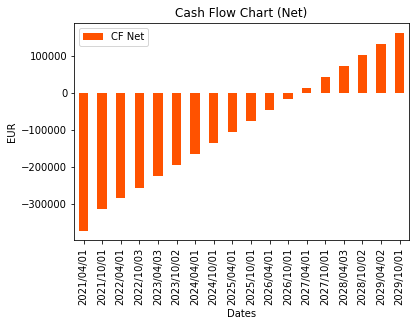

In [20]:
# We can build a cash flow table from the 'cashflows' of the response
cashflows = results.data[0]['Analytic/default/Cashflows']

labels = cashflows['slices']['Pay']['labelsY']
cf_pay = cashflows['slices']['Pay']['values']
cf_rec = cashflows['slices']['Receive']['values']

data ={
    'Dates':[keys for keys, values in labels.items()],
    'CF Pay':[values for keys, values in cf_pay.items()],
    'CF Receive':[values for keys, values in cf_rec.items()],
}

# Create a dataframe and add a 'Net' column
cf_table = pd.DataFrame(data)
cf_table['CF Net'] = cf_table['CF Pay']+cf_table['CF Receive']

cf_table.plot.bar(x='Dates', y='CF Net', color = '#ff5200')
plt.title('Cash Flow Chart (Net)')
plt.ylabel('EUR')
display(cf_table)
plt.show()

## 3. Historical Cash Flows

### 3.1 Update Fixings for Historical Resets

With our previous example being a dated 10y EUR swap, we would imagine our portfolio to have incurred some impacts to its cash balance as a result of an outlfow/inflow on payment dates. These can be illustrated in LUSID by creating transactions that adjust the cash balance.

For historical cash flows, we will need some market data again in order to determine the fixings on our floating leg, which in our example we've previously uploaded. We can use the `QuotesApi` to query the Euribor 6M fixings as shown below. 

In [21]:
# Create a quotes filter
quotes_filter = f"quoteId.quoteSeriesId.instrumentId eq 'EUR6M'"

def get_quotes(scope, quotes_filter):
    response = quotes_api.list_quotes_for_scope(
        scope=scope,
        filter=quotes_filter
    )
    return response
    
# Get resets and store values   
quotes = get_quotes(market_data_scope, quotes_filter).values
dates = [quote.quote_id.effective_at[0:10] for quote in quotes]
fixings = [quote.metric_value.value * 100 for quote in quotes]
resets_df = pd.DataFrame({'Dates': dates, 'Fixings': fixings}).drop_duplicates(['Dates'])
resets_df

,Dates,Fixings
0,2020-10-01,-0.48
1,2020-04-01,-0.28
2,2019-10-01,-0.38
3,2019-04-01,-0.23
4,2020-10-30,-0.48


Next, we will query the payment dates from our swap instrument, which can be done with a similar aggregation as used previously for valuation purposes. However, in this case we will only query _HoldingCashFlows_, as we will need to use a historical effective date which wouldn't work when calling _valuation_ as we are missing the historical curve data. (Naturally, with historical curve data in LUSID, we could query using the same function as above.)

In [22]:
def aggregate_dates(scope, portfolio, recipe, effective_at):
    aggregation_request = models.AggregationRequest(
        effective_at=effective_at.isoformat(),
        inline_recipe=recipe,
        metrics=[
        models.AggregateSpec(key='Analytic/default/HoldingCashflows',
                             op='Value')]
            )
                        
    return aggregation_api.get_aggregation(scope=scope, 
                                           code=portfolio,
                                           aggregation_request=aggregation_request)
            

results = aggregate_dates(tradingScope, tradingCode, irs_pricing_recipe, start_date)
payment_dates = results.data[0]['Analytic/default/HoldingCashflows']['slices']['Pay']['labelsY']
payment_dates = [keys.replace('/','-') for keys, values in payment_dates.items()]

In [23]:
# Check payment dates against fixings and create a cashflow table
payment_frq = 2

df = resets_df[resets_df['Dates'].isin(payment_dates)]
df['Receive'] = df.loc[:,["Fixings"]]/(payment_frq * 100) * dom_amount
df['Pay'] = [250000.0, 250000.0]
df

<ipython-input-23-0f1adcfa348c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Receive'] = df.loc[:,["Fixings"]]/(payment_frq * 100) * dom_amount
<ipython-input-23-0f1adcfa348c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Pay'] = [250000.0, 250000.0]


,Dates,Fixings,Receive,Pay
0,2020-10-01,-0.48,"-120,000.00","250,000.00"
1,2020-04-01,-0.28,"-69,000.00","250,000.00"


### 3.2 Create Transactions with Properties

Using our EUR006M fixings, we can determine the historical cash flows that would have taken place prior to today's valuation. Within LUSID, these can be stored using separate holding keys, which are a special type of transaction property that allow a user to differentiate between transactions on the same instrument. You can learn more about these type of properties [here](https://support.finbourne.com/how-are-subholding-keys-used-to-capture-different-investment-strategies). 

In our example the property will allow us to distinguish between cash flows that come from the pay/receive legs. Naturally, these could be applied using different property definitions as well, such as relating to a particular broker, custodian, fund accountant, etc.   

In [24]:
# Setup transaction property
domain = "Transaction"
scope = tradingScope
property_code = "LegSide"

try:
    property_definitions_api.create_property_definition(
        create_property_definition_request=lusid.models.CreatePropertyDefinitionRequest(
            domain = domain,
            scope = scope,
            code = property_code,
            value_required = None,
            display_name = "Pay/Receive Cash Flow Key",
            data_type_id = lusid.ResourceId(scope="system", code="string"),
            life_time = None
        )
    )

except lusid.exceptions.ApiException as e:
    print(json.loads(e.body)["title"])

Error creating Property Definition 'Transaction/Finbourne-Examples/LegSide' because it already exists.


In [25]:
# Book cash transactions - 1st Payment Date
cashTransaction1 = models.TransactionRequest(
    transaction_id="TXN002",
    type="FundsOut",
    instrument_identifiers={"Instrument/default/Currency":"EUR"},
    transaction_date=fix_date_2.isoformat(),
    settlement_date=fix_date_2.isoformat(),
    units=250000.00,
    transaction_price=models.TransactionPrice(price=1,type="Price"),
    total_consideration=models.CurrencyAndAmount(amount=1,currency="EUR"),
    exchange_rate=1,
    transaction_currency="EUR",
    properties = {f"Transaction/{tradingScope}/{property_code}" : lusid.PerpetualProperty(
        key = f"Transaction/{tradingScope}/{property_code}",
        value = lusid.PropertyValue(label_value = "Pay")
    )             
                 }
)

cashTransaction2 = models.TransactionRequest(
    transaction_id="TXN003",
    type="FundsIn",
    instrument_identifiers={"Instrument/default/Currency":"EUR"},
    transaction_date=fix_date_2.isoformat(),
    settlement_date=fix_date_2.isoformat(),
    units=-82500.00,
    transaction_price=models.TransactionPrice(price=1,type="Price"),
    total_consideration=models.CurrencyAndAmount(amount=1,currency="EUR"),
    exchange_rate=1,
    transaction_currency="EUR",
    properties = {f"Transaction/{tradingScope}/{property_code}" : lusid.PerpetualProperty(
        key = f"Transaction/{tradingScope}/{property_code}",
        value = lusid.PropertyValue(label_value = "Receive")
    )             
                 }
)


# Book cash transactions - 2nd Payment Date
cashTransaction3 = models.TransactionRequest(
    transaction_id="TXN004",
    type="FundsOut",
    instrument_identifiers={"Instrument/default/Currency":"EUR"},
    transaction_date=fix_date_3.isoformat(),
    settlement_date=fix_date_3.isoformat(),
    units=250000.00,
    transaction_price=models.TransactionPrice(price=1,type="Price"),
    total_consideration=models.CurrencyAndAmount(amount=1,currency="EUR"),
    exchange_rate=1,
    transaction_currency="EUR",
    properties = {f"Transaction/{tradingScope}/{property_code}" : lusid.PerpetualProperty(
        key = f"Transaction/{tradingScope}/{property_code}",
        value = lusid.PropertyValue(label_value = "Pay")
    )             
                 }
)

cashTransaction4 = models.TransactionRequest(
    transaction_id="TXN005",
    type="FundsIn",
    instrument_identifiers={"Instrument/default/Currency":"EUR"},
    transaction_date=fix_date_3.isoformat(),
    settlement_date=fix_date_3.isoformat(),
    units=-69000.00,
    transaction_price=models.TransactionPrice(price=1,type="Price"),
    total_consideration=models.CurrencyAndAmount(amount=1,currency="EUR"),
    exchange_rate=1,
    transaction_currency="EUR",
    properties = {f"Transaction/{tradingScope}/{property_code}" : lusid.PerpetualProperty(
        key = f"Transaction/{tradingScope}/{property_code}",
        value = lusid.PropertyValue(label_value = "Receive")
    )             
                 }
)


response = transaction_portfolios_api.upsert_transactions(scope=tradingScope,
                                                    code=tradingCode,
                                                    transaction_request=[
                                                        cashTransaction1, 
                                                        cashTransaction2, 
                                                        cashTransaction3, 
                                                        cashTransaction4
                                                    ])

### 3.3 Aggregate Cash Flows

With the transactions updated into the portfolio, we can now query the holdings which will include our updated total cash balance. Given the negative rates on the floating leg, we can see that the original EUR 1MM is reduced significantly as a result of this. In order to run the query, we use the [**get_holdings**](https://www.lusid.com/docs/api/#operation/GetHoldings) call with a reference to our portfolio's scope and code. 

In [26]:
response = transaction_portfolios_api.get_holdings(
    scope=tradingScope, 
    code=tradingCode, 
    property_keys=["Instrument/default/Name"], 
 
)
df_balance = pd.DataFrame({'Current Balance' : [response.values[1].settled_units]})
df_balance

,Current Balance
0,"348,499.00"


Using the previously set transaction properties, we can now query these to distinguish between different types of cash inflows and outfows. We should now be able to separate pay/receive-leg cash flows. Without the transaction key-value pairs, this might be difficult in a larger book of swaps, given that the receiving cash flows are negative.

Using the same API, we can run the [**get_transactions**](https://www.lusid.com/docs/api/#operation/GetTransactions) call for the scope of our portfolio. Additionally, since we are looking to separate based on values of the transaction property we can add a property filter to the call which results in the following to datasets.

In [27]:
response_pay = transaction_portfolios_api.get_transactions(scope = tradingScope, 
                                                           code = tradingCode,
                                                           filter = f"properties.Transaction/{tradingScope}/{property_code} eq 'Pay'")

response_rec = transaction_portfolios_api.get_transactions(scope = tradingScope, 
                                                           code = tradingCode,
                                                           filter = f"properties.Transaction/{tradingScope}/{property_code} eq 'Receive'")

df_pay = lusid_response_to_data_frame(response_pay.values)
df_rec = lusid_response_to_data_frame(response_rec.values)

display(df_pay)
display(df_rec)

,transaction_id,type,instrument_identifiers.Instrument/default/Currency,instrument_uid,transaction_date,settlement_date,units,transaction_price.price,transaction_price.type,total_consideration.amount,total_consideration.currency,exchange_rate,transaction_currency,properties.Transaction/Finbourne-Examples/LegSide.key,properties.Transaction/Finbourne-Examples/LegSide.value.label_value
0,TXN002,FundsOut,EUR,CCY_EUR,2020-04-01 00:00:00+00:00,2020-04-01 00:00:00+00:00,"250,000.00",1.00,Price,1.00,EUR,1.00,EUR,Transaction/Finbourne-Examples/LegSide,Pay
1,TXN004,FundsOut,EUR,CCY_EUR,2020-10-01 00:00:00+00:00,2020-10-01 00:00:00+00:00,"250,000.00",1.00,Price,1.00,EUR,1.00,EUR,Transaction/Finbourne-Examples/LegSide,Pay


,transaction_id,type,instrument_identifiers.Instrument/default/Currency,instrument_uid,transaction_date,settlement_date,units,transaction_price.price,transaction_price.type,total_consideration.amount,total_consideration.currency,exchange_rate,transaction_currency,properties.Transaction/Finbourne-Examples/LegSide.key,properties.Transaction/Finbourne-Examples/LegSide.value.label_value
0,TXN003,FundsIn,EUR,CCY_EUR,2020-04-01 00:00:00+00:00,2020-04-01 00:00:00+00:00,"-82,500.00",1.00,Price,1.00,EUR,1.00,EUR,Transaction/Finbourne-Examples/LegSide,Receive
1,TXN005,FundsIn,EUR,CCY_EUR,2020-10-01 00:00:00+00:00,2020-10-01 00:00:00+00:00,"-69,000.00",1.00,Price,1.00,EUR,1.00,EUR,Transaction/Finbourne-Examples/LegSide,Receive
